In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
from itertools import product
from sklearn.preprocessing import OneHotEncoder
warnings.filterwarnings("ignore")

2025-08-03 15:59:31.614776: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754236771.859227      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754236771.932641      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_df = pd.read_csv("/kaggle/input/preprocessed-dataset/preprocessed_train.csv")
test_df = pd.read_csv("/kaggle/input/preprocessed-dataset/preprocessed_test.csv")

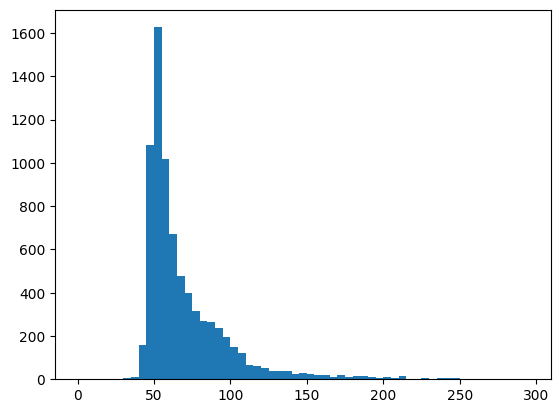

In [3]:
seq_ids = train_df["sequence_id"].values
seq_counters = train_df["sequence_counter"].values
seq_starts = np.array(train_df[train_df["sequence_counter"]==0].index)
seq_lengths = np.diff(np.concatenate([seq_starts, np.array([len(train_df)])]), n=1)

bins = np.arange(0, 300, 5)
plt.hist(seq_lengths, bins=bins)
plt.show()

In [4]:
print(f"Quantile 0.95: {np.quantile(seq_lengths, 0.95)}")
print(f"Max length: {seq_lengths.max()}")

Quantile 0.95: 127.0
Max length: 700


In [5]:
train_df["sequence_type"].unique()

array(['Target', 'Non-Target'], dtype=object)

In [6]:
type_mapping = {"Target": 1, "Non-Target": 0}
train_df["sequence_type"] = train_df["sequence_type"].map(type_mapping)

In [7]:
gestures = pd.get_dummies(train_df["gesture"])
train_df = pd.concat([train_df, gestures], axis=1)
train_df = train_df.drop(["gesture"], axis=1)

In [8]:
gesture_mapping = {gesture: i for i, gesture in enumerate(gestures)}

In [9]:
from sklearn.model_selection import train_test_split
tf.random.set_seed(42)
acc_columns = ["acc_r", "acc_theta", "acc_phi"]
rot_columns = ["rot_omega", "rot_u_theta", "rot_u_phi"]
thm_columns = ["thm_mean"]

i_list = range(1, 6)
j_list = range(64)
comb = list(product(i_list, j_list))
tof_columns = [f"tof_{i}_v{j}" for i, j in comb]

def create_dataset(df, max_length=100, batch_size=16, mode="train", train_size=0.8):
    seq_ids = df["sequence_id"].values
    seq_counters = df["sequence_counter"].values
    seq_starts = np.array(df[df["sequence_counter"]==0].index)
    seq_lengths = np.diff(np.concatenate([seq_starts, np.array([len(df)])]), n=1)
    
    images = df[tof_columns].to_numpy()   # (samples, 5*64)
    images = images.reshape(-1, 64, 5)
    images = images.reshape(-1, 8, 8, 5)
    images = tf.convert_to_tensor(images, dtype=tf.float32)

    others = df[acc_columns + rot_columns + thm_columns].to_numpy()
    others = tf.convert_to_tensor(others, dtype=tf.float32)

    feature_columns = ['adult_child', 'age', 'sex', 'height_cm', 
                       'shoulder_to_wrist_cm', 'elbow_to_wrist_cm']
    features = df[feature_columns].to_numpy()
    features = tf.convert_to_tensor(features, dtype=tf.float32)

    if mode != "test":
        sequence_types = df[["sequence_type"]].values
        gestures = df[gesture_mapping.keys()].values
        targets = np.concatenate([sequence_types, gestures], axis=1)
        targets = tf.convert_to_tensor(targets, dtype=tf.float32)
        inputs = (images, others, features, targets)
        inputs, targets = create_window(inputs, seq_starts, seq_lengths, 
                                        max_length, mode)
        ids = np.arange(len(targets))
        train_ids, valid_ids = train_test_split(ids, train_size=train_size, stratify=tf.argmax(targets[:, 1:], axis=-1), random_state=42)
        inputs_train = (
            tf.gather(inputs[0], train_ids),
            tf.gather(inputs[1], train_ids),
            tf.gather(inputs[2], train_ids)
        )
        inputs_valid = (
            tf.gather(inputs[0], valid_ids),
            tf.gather(inputs[1], valid_ids),
            tf.gather(inputs[2], valid_ids)
        )
        targets_train, targets_valid = tf.gather(targets, train_ids), tf.gather(targets, valid_ids)
        type_train_ds = tf.data.Dataset.from_tensor_slices((inputs_train, targets_train[:, :1]))
        type_train_ds = type_train_ds.shuffle(len(inputs_train)).batch(batch_size)
        gesture_train_ds = tf.data.Dataset.from_tensor_slices((inputs_train, targets_train[:, 1:]))
        gesture_train_ds = gesture_train_ds.shuffle(len(inputs_train)).batch(batch_size)

        type_valid_ds = tf.data.Dataset.from_tensor_slices((inputs_valid, targets_valid[:, :1]))
        type_valid_ds = type_valid_ds.shuffle(len(inputs_valid)).batch(batch_size)
        gesture_valid_ds = tf.data.Dataset.from_tensor_slices((inputs_valid, targets_valid[:, 1:]))
        gesture_valid_ds = gesture_valid_ds.shuffle(len(inputs_valid)).batch(batch_size)
        return type_train_ds, type_valid_ds, gesture_train_ds, gesture_valid_ds
    else:
        inputs = (images, others, features)
        inputs = create_window(inputs, seq_starts, seq_lengths, 
                               max_length, mode)
        test_ds = tf.data.Dataset.from_tensor_slices(inputs)
        test_ds = test_ds.batch(batch_size)
    return test_ds


def create_window(inputs, seq_starts, seq_lengths, max_length=100, mode="train"):
    images = inputs[0]
    others = inputs[1]
    features = inputs[2]

    image_windows = []
    other_windows = []
    feature_windows = []

    if mode != "test":
        targets = inputs[3]
        target_windows = []
    
    for start, length in zip(seq_starts, seq_lengths):
        if length < max_length:
            image_window = images[start:start+length]
            other_window = others[start:start+length]
        else:
            image_window = images[start:start+max_length]
            other_window = others[start:start+max_length]
        feature_window = features[start]
        if mode != "test":
            target_window = targets[start]
        if length < max_length:
            image_window = tf.pad(image_window, 
                                  tf.constant([[0, max_length-length],
                                               [0, 0],
                                               [0, 0],
                                               [0, 0]]), constant_values=0.0)
            other_window = tf.pad(other_window, 
                                  tf.constant([[0, max_length-length],
                                               [0, 0]]), constant_values=0.0)
        image_windows.append(image_window)
        other_windows.append(other_window)
        feature_windows.append(feature_window)
        if mode != "test":
            target_windows.append(target_window)

    image_windows = tf.stack(image_windows)
    other_windows = tf.stack(other_windows)
    feature_windows = tf.stack(feature_windows)

    if mode != "test":
        target_windows = tf.stack(target_windows)
        return (image_windows, other_windows, feature_windows), target_windows
    else:
        return (image_windows, other_windows, feature_windows)

In [10]:
def get_sequence_targets(df):
    seq_ids = df["sequence_id"].values
    seq_starts = np.array(df[df["sequence_counter"]==0].index)
    sequence_targets = df.loc[seq_starts, "sequence_type"].values
    return sequence_targets

In [11]:
gesture_columns = gestures.columns
def get_sequence_gestures(df):
    seq_ids = df["sequence_id"].values
    seq_starts = np.array(df[df["sequence_counter"]==0].index)
    sequence_gestures = df.loc[seq_starts, gesture_columns]
    return sequence_gestures

In [12]:
type_train_ds, type_valid_ds, gesture_train_ds, gesture_valid_ds = create_dataset(train_df, max_length=130, batch_size=32)

2025-08-03 16:01:38.490661: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [13]:
sequence_targets = get_sequence_targets(train_df)
print(len(sequence_targets[sequence_targets == 0]))
print(len(sequence_targets[sequence_targets == 1]))

2828
4767


In [14]:
len_target = len(sequence_targets[sequence_targets == 1])
len_non_target = len(sequence_targets[sequence_targets == 0])
type_sample_weight = (len_target/len_non_target, len_target/len_target)

In [15]:
type_sample_weight

(1.6856435643564356, 1.0)

In [16]:
gestures.columns

Index(['Above ear - pull hair', 'Cheek - pinch skin', 'Drink from bottle/cup',
       'Eyebrow - pull hair', 'Eyelash - pull hair',
       'Feel around in tray and pull out an object',
       'Forehead - pull hairline', 'Forehead - scratch', 'Glasses on/off',
       'Neck - pinch skin', 'Neck - scratch', 'Pinch knee/leg skin',
       'Pull air toward your face', 'Scratch knee/leg skin', 'Text on phone',
       'Wave hello', 'Write name in air', 'Write name on leg'],
      dtype='object')

In [17]:
non_target_gestures = ["Drink from bottle/cup", "Glasses on/off", "Pull air toward your face",
                       "Pinch knee/leg skin", "Scratch knee/leg skin", "Write name on leg",
                       "Text on phone", "Feel around in tray and pull out an object",
                       "Write name in air", "Wave hello"]
sequence_gestures = get_sequence_gestures(train_df)
all_count = sequence_gestures.sum()
non_target_count = all_count[non_target_gestures]
non_target_sum = non_target_count.sum()
all_count[non_target_gestures] = non_target_sum
all_count = non_target_sum / all_count
gesture_sample_weight = tuple(all_count.values)

In [18]:
gesture_sample_weight

(4.768971332209106,
 4.74496644295302,
 1.0,
 4.7851099830795265,
 4.768971332209106,
 1.0,
 4.7370184254606365,
 4.7370184254606365,
 1.0,
 4.705490848585691,
 4.721202003338898,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0)

In [19]:
print(len(type_train_ds))
print(len(type_valid_ds))
print(len(gesture_train_ds))
print(len(gesture_valid_ds))

190
48
190
48


In [20]:
# Check dataset shape
for i, (inputs, targets) in enumerate(type_train_ds):
    if i == 0:
        print(inputs[0].shape)        # Image (TOF)
        print(inputs[1].shape)        # Other time-series
        print(inputs[2].shape)        # Feature
        print(targets.shape)          # Target or Non-Target
        break

(32, 130, 8, 8, 5)
(32, 130, 7)
(32, 6)
(32, 1)


In [21]:
for i, (inputs, targets) in enumerate(gesture_train_ds):
    if i == 0:
        print(inputs[0].shape)        # Image (TOF)
        print(inputs[1].shape)        # Other time-series
        print(inputs[2].shape)        # Feature
        print(targets.shape)          # Gesture
        break

(32, 130, 8, 8, 5)
(32, 130, 7)
(32, 6)
(32, 18)


In [22]:
test_ds = create_dataset(test_df, max_length=130, batch_size=32, mode="test")

In [23]:
# Check dataset shape
for inputs in test_ds:
    print(inputs[0].shape)        # Image (TOF)
    print(inputs[1].shape)        # Other time-series
    print(inputs[2].shape)        # Feature

(2, 130, 8, 8, 5)
(2, 130, 7)
(2, 6)


In [24]:
import os
output_path = "/kaggle/working/"
type_train_path = os.path.join(output_path, "type_train_ds")
type_valid_path = os.path.join(output_path, "type_valid_ds")
gesture_train_path = os.path.join(output_path, "gesture_train_ds")
gesture_valid_path = os.path.join(output_path, "gesture_valid_ds")
test_path = os.path.join(output_path, "test_ds")

tf.data.experimental.save(type_train_ds, type_train_path)
tf.data.experimental.save(type_valid_ds, type_valid_path)
tf.data.experimental.save(gesture_train_ds, gesture_train_path)
tf.data.experimental.save(gesture_valid_ds, gesture_valid_path)
tf.data.experimental.save(test_ds, test_path)

In [25]:
import json

mapping_dicts = {
    "type_mapping":type_mapping, 
    "gesture_mapping": gesture_mapping
}

dict_path = os.path.join(output_path, "mapping.json")
with open(dict_path, "w") as f:
    json.dump(mapping_dicts, f, indent=2)

In [26]:
sample_weight_dicts = {
    "type_sample_weight": type_sample_weight,
    "gesture_sample_weight": gesture_sample_weight
}

dict_path = os.path.join(output_path, "sample_weight.json")
with open(dict_path, "w") as f:
    json.dump(sample_weight_dicts, f, indent=2)